# `H2MM_C` tutorial

## Import Modules

As with most python projects, we start by importing the packages that we will use:
- `os`: for basic file I/O
- [numpy](https://numpy.org) : the core of nearly all scientific computing in python
- [matplotlib](https://matplotlib.org/) : for plotting results, not needed for H<sup>2</sup>MM analysis
- `H2MM_C`: module for photon by photon hidden Markov modeling analysis


In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt

import H2MM_C as hm

## Basic Analysis

The basic steps of analysis are:

1. Load data
2. Make initial model
3. Optimize Model
4. *Viterbi* analysis to clasify photons and assess quality

> Note: steps 2-4 are usually repeated multiple times with different numbers of states, and results compared to select the ideal model.

### Step 1: Load data

Now that the data is imported, we can start to perform the basic analysis of H<sup>2</sup>MM, for which we will need some data to anlayze.
So we'll load some with the following lines of code:

In [2]:
# This cell will only be used if you export your data to an ascii file, 
# if you are using a software package such as FRETBursts, a different
# function (for FRETBursts, look at our other Jupyter Notebooks, it is
# the data_sort function)
def load_txtdata(filename):
    color = list()
    times = list()
    with open(filename,'r') as f:
        for i, line in enumerate(f):
            if i % 2 == 0:
                times.append(np.array([int(x) for x in line.split()],dtype=np.int64))
            else:
                color.append(np.array([int(x) for x in line.split()],dtype=np.uint8))
    return color, times

color2, times2 = load_txtdata('sample_data_2det.txt')

> #### Data Organization
> So what does this data look like?
> It comes 2 lists of arrays, one list contains the detectors of the data, the second the detectors of the times.
> 
> - `color2` contains the detectors (indices starting from 0)
> - `times2` contains the **absolute** times of the data
> 
> Both of these are **lists** of **numpy arrays**.
>
>> The length of both lists must be the same, because the arrays within form pairs.
>> The elements of each array also form pairs, together representing individual data points
>> Therefore the size of each pair of arrays must also be the same.
>> But the size of one pair is independent of another pair.
>
> For the next step, it is important that the number of detectors is known, as this affects the initial model to be used.
> In the example loaded above, there are 2 detectors- 0 and 1 (note indices should start from 0 and proceed in ascending order, 3 detectors must be indices 0, 1, and 2, 4 detectors 0, 1, 2, 3, and so on).

In [3]:
color2[0], times2[0]

(array([1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0],
       dtype=uint8),
 array([12763662, 12766593, 12769260, 12769677, 12775221, 12781399,
        12783890, 12795124, 12795391, 12796727, 12797800, 12798471,
        12798527, 12799163, 12799626, 12802748, 12808470, 12811473,
        12826887, 12841103, 12842716, 12842791, 12844203, 12844446,
        12845687, 12846645, 12847506, 12848115, 12850099, 12853216,
        12853259, 12853526, 12853632, 12853845, 12855027, 12858436,
        12858750, 12860935, 12861560, 12861894, 12869843]))

### Step 2: Create Initial Model

H<sup>2</sup>MM is fundamentally an optimization, which means that an initial, unoptimized model must be used to initiate the optimization so that the algorithm has a starting point.

`H2MM_C` provides a simple function for creating initial models. All you need to do is specify the number of states, and number of detectors.

> The number of states is arbitrary, as we will show later, you should compare several differnt numbers of states.>
> The number of detectors however, is determined by your data, for th file `sample_data_2det.txt`, there are 2 detectors.

So let's make the initial model syntax `hm.facotry_h2mm_model(nstate: int, ndet: int)`:

In [4]:
imodel_3s2d = hm.factory_h2mm_model(3,2) # 3 states, 2 detectors

### Step 3: Optimize model

Now that we have an initial model, we can optimize it against the data, for this use the `hm.EM_H2MM_C` function (appologies for the name, the name comes from the earliest iterations of H<sup>2</sup>MM, maintained for compatibility)

The syntax is `hm.EM_H2MM_C(init_model: hm.h2mm_model, detectors: list[numpy.ndarray], times: list[numpy.ndarray])`

In [5]:
model_3s2d = hm.EM_H2MM_C(imodel_3s2d, color2, times2)
model_3s2d

Optimization reached maximum number of iterations


nstate: 3, ndet: 2, nphot: 239701, niter: 2046, loglik: -120029.31045130274 converged state: 0x47
prior:
0.22722690429525957, 0.33564373290915145, 0.4371293627955889
trans:
0.9999737418664758, 2.6258046658597896e-05, 8.686559167309947e-11
1.4552294552341365e-05, 0.9999710726665848, 1.4375038862815986e-05
1.11601003542758e-06, 1.027046989886743e-05, 0.9999886135200656
obs:
0.30715584745797103, 0.692844152542029
0.7830412996442412, 0.21695870035575882
0.890565978960351, 0.10943402103964894

#### Examining the optimized model

The core of a `h2mm_model` is composed of 3 arrays:

- `prior` : the prior probability vector, shape: N, the probability of a system starting in a given state
- `trans` : the transition probability matrix, shape N x N, the probability of a transition happening from state i to state j.
    > Note: the units of this matrix are in the clock-rate of the data
- `obs` : the emission probability matrix: shape N x M, the probability of state i producing a photon with index j.

These are all printed as part of the repr for an `h2mm_model`

But you can also access them as numpy arrays using attributes.

This allows further calculations to be performed

In [6]:
prior_3s2d, trans_3s2d, obs_3s2d = model_3s2d.prior, model_3s2d.trans, model_3s2d
prior_3s2d, trans_3s2d, obs_3s2d

(array([0.2272269 , 0.33564373, 0.43712936]),
 array([[9.99973742e-01, 2.62580467e-05, 8.68655917e-11],
        [1.45522946e-05, 9.99971073e-01, 1.43750389e-05],
        [1.11601004e-06, 1.02704699e-05, 9.99988614e-01]]),
 nstate: 3, ndet: 2, nphot: 239701, niter: 2046, loglik: -120029.31045130274 converged state: 0x47
 prior:
 0.22722690429525957, 0.33564373290915145, 0.4371293627955889
 trans:
 0.9999737418664758, 2.6258046658597896e-05, 8.686559167309947e-11
 1.4552294552341365e-05, 0.9999710726665848, 1.4375038862815986e-05
 1.11601003542758e-06, 1.027046989886743e-05, 0.9999886135200656
 obs:
 0.30715584745797103, 0.692844152542029
 0.7830412996442412, 0.21695870035575882
 0.890565978960351, 0.10943402103964894)

Note that all the above matrices are **row stochastic**, i.e. the sum of the elements in a row is always 1.
This is because these are all probabilities, and by definition must sum to 1.
Calculate relevant parameters accordingly.

-------------------------------------------------------------

There are a number of other secondary parameter stored in `h2mm_model` objects.
Some describe the size of the matrices:

- `nstate`
- `ndet`

In [7]:
model_3s2d.nstate, model_3s2d.ndet

(3, 2)

Others are specific to the course of the optimization:

- `niter` The number of iterations during the optimization
- `nphot` The number of data points in the input data

In [8]:
model_3s2d.niter, model_3s2d.nphot

(2046, 239701)

And  finally there are the statistical parameters that reflect the likelilihood of th model:

- `loglik`: the loglikelihood of the model, this represents the value which is optimized during optimization.
- `bic`The Bayes Information Criterion, a statistical discriminator $BIC = k\ln(n) - 2\ln(LL)$ where $k = nstate^2 + (ndet-1) nstate -1$, this is used for comparing likelihoods of different models with different numbers of states. Essentially the loglikelihood always improves when more states are added, so the $BIC$ adds a penalty for the number of states, and scalles for the number of data points in the input data.

In [9]:
model_3s2d.loglik, model_3s2d.bic

(-120029.31045130274, 240194.87952612073)

### Step 4: *Viterbi* analysis

The final stage of standard H<sup>2</sup>MM analysis is analysis with the *Viterbi* algorithm.
This goes back over the data, with the optimized model, and identifies the most likely state of each data-point.

For this, we use the `hm.viterbi_path` function.
This function also returns some additional values that also come out of the *Viterbi* analysis.
The return values of `hm.viterbi_path` are:
- `path`: the most likely state of each data-point
- `scale`: the likelihood of the state assignment, i.e. the posterior probability
- `loglik`: the log likelihood of the state path per array
- `icl`: The Integrated Complete Likelihood, a statistical discriminator of models, which adds penalties for more states.

The syntax is `hm.viterbi_path(model: hm.h2mm_model, detectors: list[numpy.ndarray], times: list[numpy.ndarray])`

In [10]:
path_3s2d, scale_3s2d, ll_3s2d, icl_3s2d = hm.viterbi_path(model_3s2d, color2, times2)
path_3s2d[0]

array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=uint8)

## Loop based analysis

Since we need to compare different models, it is generally more usefull to run the analysis in a loop, and then compare the different optimizations.

In particular, the *ICL*  is very useful to identify the best model.

We will also now use a data set with 3 detectors, so we can see how different detector number affects the analysis.

#### Load 3 detector data

In [11]:
color3, times3 = load_txtdata('sample_data_3det.txt')

#### Loop analysis

For this we will start with a simple loop, optimizing for 1 to 4 states (no such thing as a 0 state model)

In [12]:
# initiate lists
models = list()
paths = list()
scales = list()
logliks = list()
ICL = list()

# loop from 1 to 4 states
for i in range(1,5):
    # make initial model with i states
    imodel_temp = hm.factory_h2mm_model(i, 3) # i states, 3 detectors
    # optimize model
    model_temp = hm.EM_H2MM_C(imodel_temp, color3, times3)
    # calculate ideal state path
    path_temp, scale_temp, ll_temp, icl = hm.viterbi_path(model_temp, color3, times3)
    # append results to lists
    models.append(model_temp)
    paths.append(path_temp)
    scales.append(scale_temp)
    logliks.append(ll_temp)
    ICL.append(icl)
models

The model converged after 1 iterations
The model converged after 86 iterations
The model converged after 198 iterations
Optimization reached maximum number of iterations


[nstate: 1, ndet: 3, nphot: 436084, niter: 1, loglik: -436870.26641812694 converged state: 0x27
 prior:
 1.0
 trans:
 1.0
 obs:
 0.40807734289723996, 0.14158969372873118, 0.45033296337402884,
 nstate: 2, ndet: 3, nphot: 436084, niter: 86, loglik: -416808.46054398845 converged state: 0x27
 prior:
 0.28420057475284805, 0.7157994252471521
 trans:
 0.9999702726865412, 2.9727313458854513e-05
 1.3614968810175137e-05, 0.9999863850311899
 obs:
 0.15584402171444742, 0.2649819739093295, 0.579174004376223
 0.5300104368940587, 0.08194015009512386, 0.38804941301081747,
 nstate: 3, ndet: 3, nphot: 436084, niter: 198, loglik: -409379.1470199392 converged state: 0x27
 prior:
 0.259916108708088, 0.4943768369469508, 0.24570705434496115
 trans:
 0.9999762009962716, 2.109156933799687e-05, 2.7074343903649875e-06
 8.392846121801858e-06, 0.9999812080448961, 1.039910898208395e-05
 6.2902830423554276e-06, 4.4662165823833337e-05, 0.9999490475511338
 obs:
 0.14570423954876827, 0.29344318300520333, 0.560852577446

#### Ideal model selection

Now that several models have been calculated, it is important to select the ideal model, so you do not use over-or under-fit models that do not propery represent the data.

There are two primary criterion for this:
1. A statistical discriminator
2. Reasonableness of model and results based on prior knowledge of the system.



Text(0.5, 1.0, 'ICL')

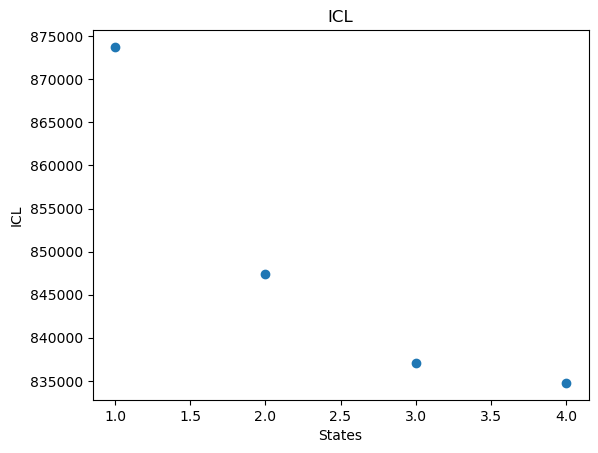

In [13]:
states = np.arange(1,5)
plt.scatter(states, ICL)
plt.xlabel("States")
plt.ylabel("ICL")
plt.title("ICL")

Text(0.5, 1.0, 'BIC')

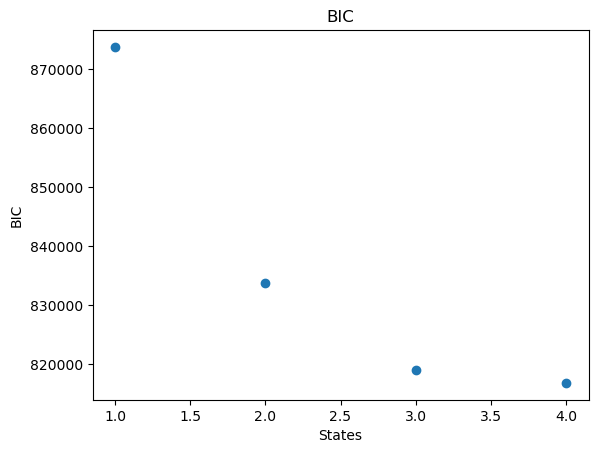

In [14]:
states = np.arange(1,5)
plt.scatter(states, [model.bic for model in models])
plt.xlabel("States")
plt.ylabel("BIC")
plt.title("BIC")

So it looks like the ideal model is the 4 state model (if you are using our sample data), as it minimizes the ICL.

But since this is the model with the most states that we have optimized, it would be best to optimize a 5 state model to make sure that we have found the optimal model:

In [15]:
imodel_temp = hm.factory_h2mm_model(5,3)
model_temp = hm.EM_H2MM_C(imodel_temp, color3, times3)
path_temp, scale_temp, ll_temp, icl = hm.viterbi_path(model_temp, color3, times3)
models.append(model_temp)
paths.append(path_temp)
scales.append(scale_temp)
logliks.append(ll_temp)
ICL.append(icl)

Optimization reached maximum number of iterations


Text(0.5, 1.0, 'BIC')

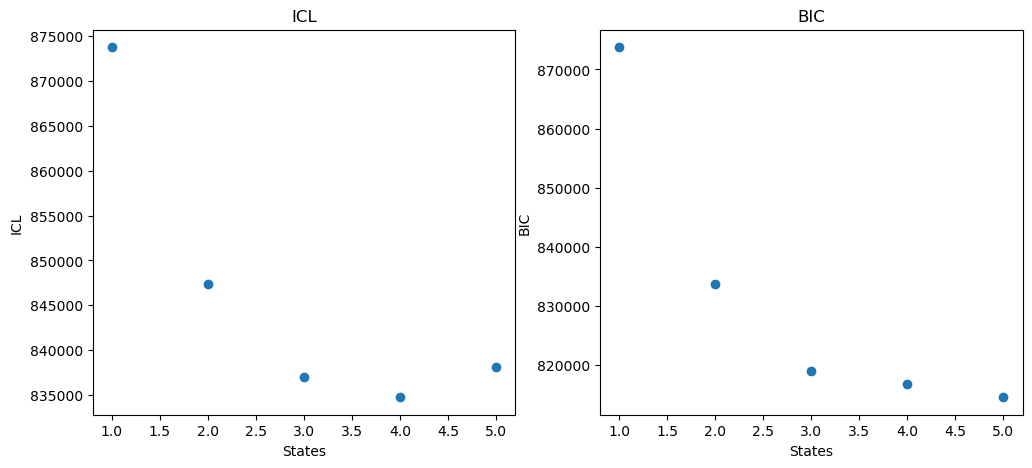

In [16]:
states = [model.nstate for model in models]
bic = [model.bic for model in models]

fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].scatter(states, ICL)
ax[0].set_xlabel("States")
ax[0].set_ylabel("ICL")
ax[0].set_title("ICL")

ax[1].scatter(states, bic)
ax[1].set_xlabel("States")
ax[1].set_ylabel("BIC")
ax[1].set_title("BIC")

Indeed, it looks like the 4 state model is the ideal model, so let's examine it:

In [17]:
models[3]

nstate: 4, ndet: 3, nphot: 436084, niter: 2046, loglik: -408231.68923972535 converged state: 0x47
prior:
0.6256723202871912, 0.030618314835205957, 0.1913554874743798, 0.15235387740322295
trans:
0.8614352909515696, 0.05949618307916635, 0.07906852596926418, 5.801412452897551e-52
1.9958918629265885e-05, 0.9999674324501578, 1.0612627869652572e-05, 1.9960033433079985e-06
4.716293407423162e-06, 6.465143004789335e-06, 0.9999788977572993, 9.920806288462867e-06
2.9502467233499893e-06, 2.6195354649815663e-06, 3.796466128735933e-05, 0.9999564655565244
obs:
0.6179991352539776, 0.3820008647460223, 4.400349171200337e-34
0.1442451406741443, 0.2895074666236848, 0.5662473927021708
0.4416360943377826, 0.08700242474765406, 0.4713614809145635
0.8409823313786843, 0.07645620183506778, 0.08256146678624778

## User Defined Initial Models

Usually the `hm.factory_h2mm_model` function is sufficient for making initial models, but it is also possible to define your own initial models with more precise initial values.

In [18]:
# define input prior, trans and obs matricies
prior = np.array([0.5,0.5])
trans = np.array([[0.99999, 0.00001], [0.00001, 0.99999]])
obs = np.array([[0.2, 0.3, 0.5], [0.4, 0.2, 0.4]])

# make the initial model
imodel_user = hm.h2mm_model(prior, trans, obs)

# optimize model
model_user = hm.EM_H2MM_C(imodel_user, color3, times3)

The model converged after 89 iterations


We can now look at the resultant model:

In [19]:
model_user

nstate: 2, ndet: 3, nphot: 436084, niter: 89, loglik: -416808.4605439837 converged state: 0x27
prior:
0.28420060371238737, 0.7157993962876127
trans:
0.999970272646437, 2.9727353563062123e-05
1.361499259531254e-05, 0.9999863850074047
obs:
0.15584401880687487, 0.26498195564167654, 0.5791740255514486
0.5300104777302175, 0.08194013963655644, 0.388049382633226

## `H2MM_arr` and error analysis

You will notice that so far the H<sup>2</sup>MM analysis does not give an estimation of the error of the parameter values.

One way to estimate the error is to compare how quickly the loglikelihood falls off as the given parameter is varied around the optimized value.

For this, we need to not optimize, but just calculate the loglikelihood of a set of models. For this, `H2MM_C` offers the `hm.H2MM_arr()` function.

The function is called as so:

`hm.H2MM_arr(models: list[hm.h2mm_model], indexes: list[numpy.ndarray], times: list[numpy.ndarray])`

The second and third arguments are the same as `hm.EM_H2MM_C`, but in the first argument, instead providing an initial model, you provide a list (or tuple, or even a numpy object array) of `hm.h2mm_model` objects. 
The loglikelihood of each model is calculated, and the function returns a equialent list of `hm.h2mm_model` objects, with the loglikelihoods calculated.

### Make list of models with one parameter varied

Since the 4 state model looks like the best model, let's pull that model and tweek the transition rate from state 1 to state 2:

In [20]:
# pull out the parameters of the model
prior_4s3d = models[3].prior
trans_4s3d = models[3].trans
obs_4s3d = models[3].obs

error_models = list()
for tk in np.linspace(-2e-6, 2e-6, 41):
    new_trans = trans_4s3d.copy() # copy so that tweeks can be make without changing the original array
    new_trans[1,2] += tk
    new_trans[1,1] -= tk # adjust the diagonal so that matrix remains row stochastic
    tk_model = hm.h2mm_model(prior_4s3d, new_trans, obs_4s3d)
    error_models.append(tk_model)

Now, we can use `hm.H2MM_arr()`

In [21]:
error_models = hm.H2MM_arr(error_models, color3, times3)

Now we can plot the loglik to see how sharply the loglikelihood is centered on the optimal model

(8.562627869652573e-06, 1.2662627869652568e-05)

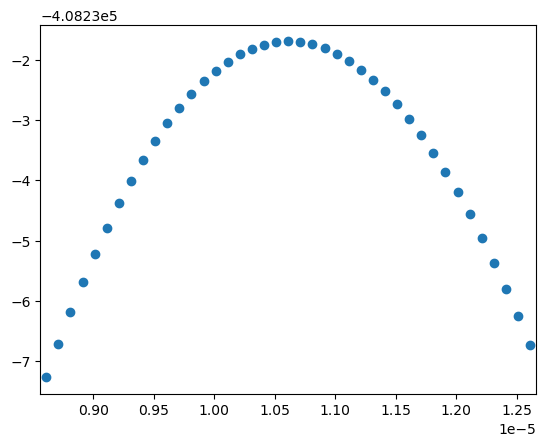

In [22]:
trs  = [model.trans[1,2] for model in error_models]
ll = [model.loglik for model in error_models]

plt.scatter(trs, ll)
plt.xlim([min(trs)-5e-8, max(trs)+5e-8])